<a href="https://colab.research.google.com/github/Siddikpatel/assignment-5/blob/main/CSCI6908_Assignment_5_Finetuning_and_PEFT_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Finetuning and PEFT Methods.
<b style="color:red;bold;">Due date: April 2nd, 2025</b>

## Introduction

In the previous assignment, you explored the inner workings of a Transformer model by pretraining it from scratch. While this process can be valuable in certain scenarios, it may not be practical in many others. The primary reason is that for a model to acquire a substantial amount of knowledge, it requires vast amounts of data coupled with a model size of billions of parameters. This approach can be prohibitively expensive when using consumer-grade hardware.  

An alternative paradigm is the pretrain-finetune approach. In this method, a model that has already been pretrained (typically by entities with access to large computing infrastructure, such as tech companies) is then adapted (or finetuned) for a specific task.  

While the pretrain-finetune approach offers significant advantages over training from scratch, it still presents challenges when working with large language models. Finetuning the entire model requires substantial computational resources. It also acan lead to catastrophic forgetting of previously learned knowledge. To address these limitations, Parameter-Efficient Fine-Tuning (PEFT) methods have been developed. PEFT techniques allow for the adaptation of pre-trained models to specific tasks while updating only a small subset of the model's parameters. This approach drastically reduces the computational and memory requirements for fine-tuning, making it feasible to adapt large language models on consumer-grade hardware. Moreover, PEFT methods help preserve the model's general knowledge while effectively learning task-specific information, striking a balance between efficiency and performance.  

In this assignment, you will run a battery of experiments to compare the effect of different finetuning strategies on a model's performance given a downstream task.  



## Part 0: Preliminary

### Libraries

The assignment mainly relies on two libraries developped by Huggingface:
- `transformers`: A comprehensive library that provides state-of-the-art pre-trained models for Natural Language Processing (NLP) and other tasks, offering easy-to-use interfaces for implementing, and fine-tuning a wide range of transformer-based architectures.  
- `datasets`: A library for accessing NLP datasets. (Note that you can skip using this library, however, it is very handy when it comes to loading and preprocessing public datasets).
- `peft`: A specialized library designed to implement various parameter-efficient fine-tuning methods.

In case you are unfamiliar with these libraries, you can consult these resources:
- [Stanford's CS224N transformers tutorial](https://colab.research.google.com/drive/1pxc-ehTtnVM72-NViET_D2ZqOlpOi2LH?usp=sharing)
- [The `peft`'s library documentation page](https://huggingface.co/docs/peft/en/index)
- [The `datasets` library documentation page](https://huggingface.co/docs/datasets/quickstart#nlp)

### (!New!) Required Reading Material
Compared to other assignments, you will need to go over the following reading materials:
- Video: [EMNLP 2022 Tutorial - "Modular and Parameter-Efficient Fine-Tuning for NLP Models"](https://youtu.be/KoOlcX3XLd4?si=jKh2FCwETnrydJND)
- Blog: [PEFT - Parameter Efficient Fine-Tuning: A Survey](https://aiwithmike.substack.com/p/peft-parameter-efficient-fine-tuning?utm_campaign=post&utm_medium=web)

These materials provide a comprehensive overview and recent advances in the domain of PEFT methods. **The quiz will include questions related to some of the concepts addressed there**.

### Model

In this assignment you will use the RoBERTa base model. It roughly has 125M parameters. It bears similar architecture to BERT. The difference lays in the pretraining tasks. You can find the model on Huggingface's [hub](https://huggingface.co/FacebookAI/roberta-base). If you want, you can choose a bigger model. However, you cannot choose a model whose parameter size is less than RoBERTa's.

### Task

The General Language Understanding Evaluation (GLUE) benchmark is a collection of diverse natural language understanding tasks designed to evaluate and compare the performance of machine learning models across a range of language processing challenges. In this assignment, you will finetune and evaluate the aforemention model on the Corpus of Linguistic Acceptability (CoLA) task. CoLA is a collection of English sentences labeled as either grammatically acceptable or unacceptable, used to evaluate a model's ability to distinguish between well-formed and ill-formed sentences. It is basically a binary classification task. You can find the dataset on Huggingface's [hub](https://huggingface.co/datasets/nyu-mll/glue/viewer/cola).


### Recommendations
This assignment involves finetuning a model multiple times under different settings. This might take a while, so make sure to start working on the assignment early. Second, you may be working on the free tier of Colab, which means you will have limited access to the GPU it offers. Hence, make sure to save the output of each cell regularly so that you do not have to rerun it again (whenever this is applicable). Third, in the majority of questions, you will be asked to report results after running multiple experiments. This might not be possible to do within one session since you may loose access to Colab's GPUs for a certain period of time (another reason why you should start early!). To overcome this, make sure that you save the results of each experiment locally, so that when you start a new session, you do not have to rerun everything from the beginning.

## Submission Guidelines
- Add the TA as _Maintainer_ to your fork and submit your fork's URL on Brightspace. Push the modifications you have made on this notebook to your fork.  
- **Please note that a missing Brightspace submission will be treated as a non-submissiom, even if you have added the TA to your fork.**  
- **If you have stored raw results locally (e.g. in CSV or JSON files), you need to push those as well.**  
- **It is important that the cells of the Jupyter notebook reflect what is required in each part. For example, if a question asks you to finetune a model with varrying number of frozen layers (e.g. 2, 4 and 6), you should create three cells where each one corresponds to each setting. Becareful, to not override the same cell.**

## Submission of SDAs
For this assignment, SDAs should be submitted through Brightspace. You will find the submission box under _Assignments_ > _SDA_. **<span style="color:red">Please note that you are only allowed to submit 2 SDAs for this course. Hence, if you already reached that limit, you can no longer submit one. In addition, no SDA will be considered if sent by email. All SDAs should be submitted through Brightspace at least 24 hours prior to the deadline. The PDF file should be following this format: `<BANNER-ID>_<FIRST-NAME>_<LAST_NAME>_<ASSIGNMENT-NUMBER>.pdf`</span>**  

If you have any questions, please do not hesitate to post them on the course’s Teams channel. If you have not joined already, you can do so by using this code: `ot45hmp`.

Good luck!

## Part 1: Full Finetuning

In this part, you are tasked with fully fine-tuning the RoBERTa model, or the model that you have chosen, on the CoLA dataset. You may utilize the built-in classes for model definition and training provided by the `transformers` library. It is worth noting that many of these classes, particularly those used to load model weights from the hub, are essentially PyTorch classes at their core. This means they can serve as building blocks for other PyTorch models, offering you flexibility in your implementation. The decision of whether to use the `transformers` classes extensively or to employ only a subset of them to tackle the CoLA task is left to your.  

Given the nature of the task, choose one adequate performance metric. In addition, report the time taken to finetune the model.

In [2]:
pip install datasets

In [3]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import matthews_corrcoef
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt

In [4]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    mcc = matthews_corrcoef(labels, predictions)
    return {"matthews_correlation": mcc}

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="matthews_correlation",
    greater_is_better=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

In [7]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
dataset = load_dataset("glue", "cola")

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

start_time = time.time()

train_results = trainer.train()

end_time = time.time()

training_time = end_time - start_time
training_time_formatted = str(timedelta(seconds=training_time))

eval_results = trainer.evaluate()

mcc_score = eval_results["eval_matthews_correlation"]

print("\n" + "="*20)
print("PERFORMANCE REPORT")
print("="*20)
print(f"Model: {model_name}")
print(f"Training time: {training_time_formatted}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_score:.4f}")
print("="*20)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: patel-siddik369 (patel-siddik369-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.461900,0.429097,0.574557



PERFORMANCE REPORT
Model: roberta-base
Training time: 3:00:04.989456
Matthews Correlation Coefficient (MCC): 0.5746


## Part 2: Layer Freezing

In this part of the assignment, you will fine-tune RoBERTa using layer freezing and analyze its impact on performance.  

Layer freezing involves keeping certain layers of a pre-trained model fixed during fine-tuning, updating only the parameters of the unfrozen layers.

1. Your task is to experiment with freezing the first $k$ layers of the RoBERTa model, where $k$ takes the values 2, 4, 6, 8, and 10. For example, when $k$ = 6, freeze the first 6 layers of the model, leaving the remaining layers trainable. To freeze a layer in PyTorch, set the `requires_grad` attribute of its parameters to `False`. This prevents gradient computation for these parameters during backpropagation. Implement this freezing strategy for each value of $k$, fine-tune the model on the CoLA dataset, and evaluate its performance on the test set. You will also need to calculate the time taken to finetune the model under each value of $k$.

2. After completing all experiments, you will need to plot two lineplots. The first will be the performance as a function of the number of frozen layers ($k$). The second plot will be the running time as function of $k$. Describe both of plots and state whether a possible relationship exists, and if so, does it make sense and why.

In [9]:
import json
import os

results_file = "results.json"

if os.path.exists(results_file):
    with open(results_file, "r") as f:
        saved_results = json.load(f)
        saved_k_values = saved_results.get("k_values", [])
        saved_performance = saved_results.get("performance_results", [])
        saved_training_times = saved_results.get("training_times", [])
else:
    saved_k_values = []
    saved_performance = []
    saved_training_times = []

In [10]:
# Function to freeze the first k layers of the model
def freeze_layers(model, k):
    for param in model.roberta.embeddings.parameters():
        param.requires_grad = False
    for i in range(k):
        for param in model.roberta.encoder.layer[i].parameters():
            param.requires_grad = False

model.safetensors:   8%|8         | 41.9M/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: patel-siddik369 (patel-siddik369-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.452600,0.425390,0.521744


Completed k=2, MCC=0.5217440302138174, Time=2:38:38.882280s


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.441400,0.434882,0.548133


Completed k=4, MCC=0.5481326292844919, Time=2:18:01.163466s


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.448300,0.450634,0.521376


Completed k=6, MCC=0.5213763355102656, Time=1:59:32.206596s


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.455700,0.453887,0.494327


Completed k=8, MCC=0.4943270618905556, Time=1:41:48.852417s


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.480800,0.476836,0.482941


Completed k=10, MCC=0.48294129936559577, Time=1:23:12.258317s


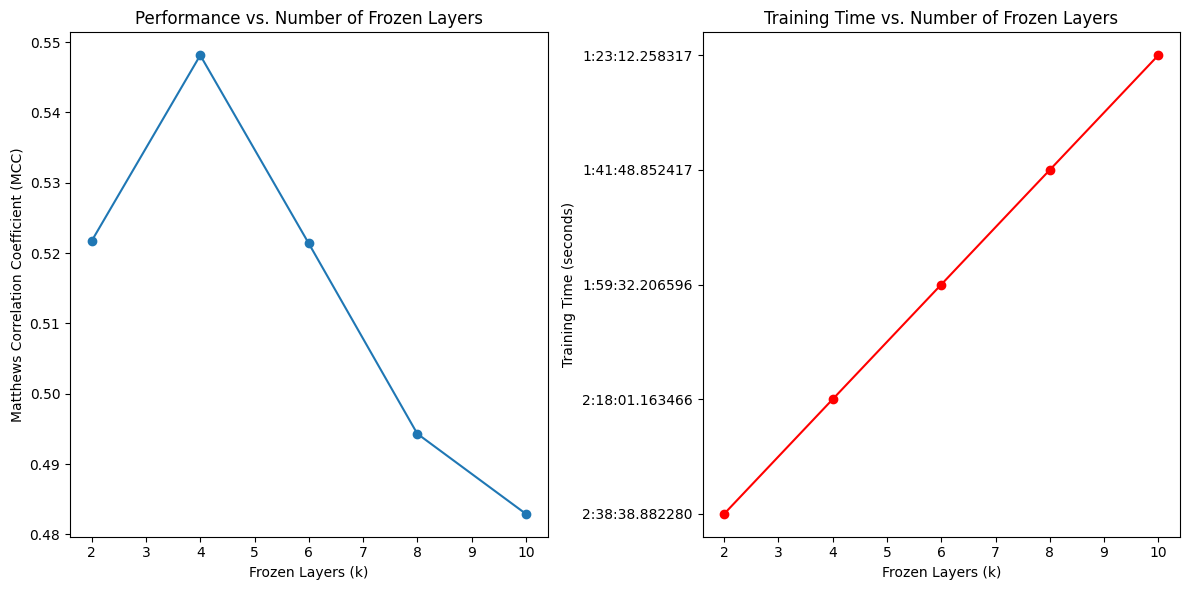

In [ ]:
k_values = [2, 4, 6, 8, 10]

for k in k_values:
    if k in saved_k_values:
        print(f"k={k}, already computed.")
        continue

    # Reload the model to reset weights
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Freeze the first k layers
    freeze_layers(model, k)

    # Create a new trainer with the updated model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()

    training_time = str(timedelta(seconds=end_time - start_time))
    eval_results = trainer.evaluate()
    mcc_score = eval_results["eval_matthews_correlation"]

    saved_k_values.append(k)
    saved_performance.append(mcc_score)
    saved_training_times.append(training_time)

    with open(results_file, "w") as f:
        json.dump(
            {
                "k_values": saved_k_values,
                "performance_results": saved_performance,
                "training_times": saved_training_times,
            },
            f,
            indent=4,
        )

    print(f"Completed k={k}, MCC={mcc_score}, Time={training_time}s")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(saved_k_values, saved_performance, marker="o")
plt.xlabel("Frozen Layers (k)")
plt.ylabel("Matthews Correlation Coefficient (MCC)")
plt.title("Performance vs. Number of Frozen Layers")

plt.subplot(1, 2, 2)
plt.plot(saved_training_times, saved_k_values, marker="o", color="r")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Frozen Layers (k)")
plt.title("Training Time vs. Number of Frozen Layers")

plt.tight_layout()
plt.show()

## Part 3: Prefix Tuning

Now you will explore prefix tuning, another PEFT technique for large language models. Prefix tuning involves prepending a trainable prefix to the input of each transformer layer while keeping the pre-trained model parameters frozen. This approach allows for task-specific adaptation with a significantly smaller number of trainable parameters compared to full fine-tuning. Your task is to implement prefix tuning for the RoBERTa model on the CoLA dataset.

1. Use the `peft` library to add trainable prefixes to each layer of the model. Specifically, experiment with different prefix lengths $L$ = 10, 30, 50, 100.
2. Draw two line plots showing the relationship between prefix length and model performance on the test set, and between the prefix length and finetuning time.

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: patel-siddik369 (patel-siddik369-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.599200,0.618537,0.000000


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Completed Prefix Tuning with L=10, MCC=0.0000, Time=2:13:45.152706


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.600900,0.617135,0.000000


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Completed Prefix Tuning with L=30, MCC=0.0000, Time=2:13:42.229242


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.598000,0.618754,0.000000


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Completed Prefix Tuning with L=50, MCC=0.0000, Time=2:15:23.485139


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.601000,0.615975,0.000000


Completed Prefix Tuning with L=100, MCC=0.0000, Time=2:22:43.112988


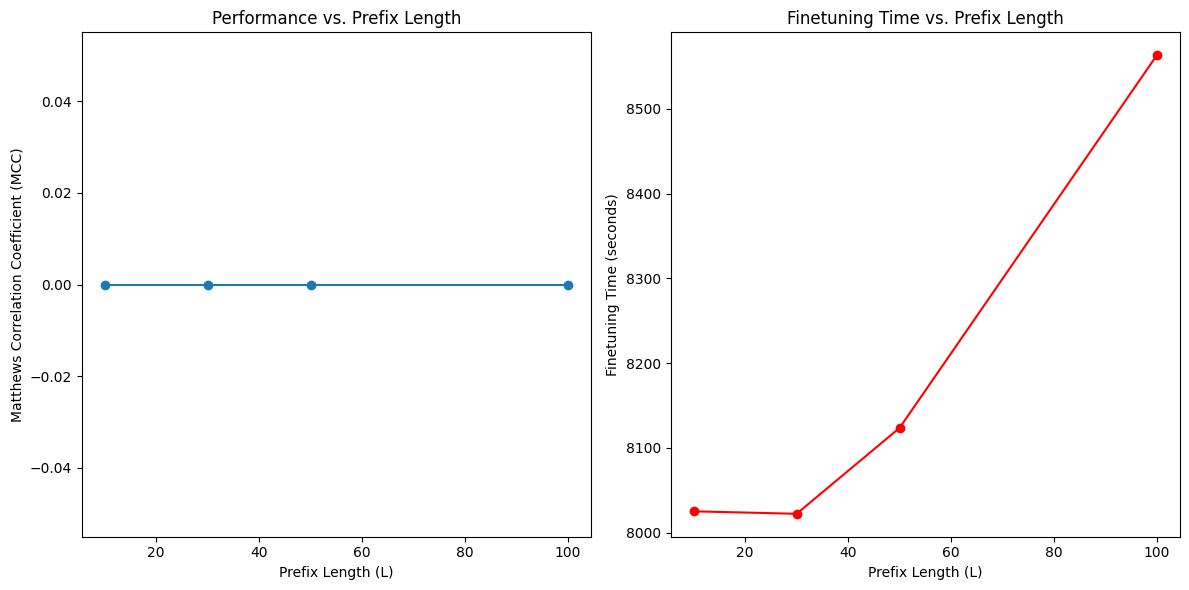

In [12]:
from peft import PrefixTuningConfig, get_peft_model
import time
from datetime import timedelta
import matplotlib.pyplot as plt

model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

prefix_lengths = [10, 30, 50, 100]

performance_results = []
finetuning_times = []

for prefix_length in prefix_lengths:

    prefix_config = PrefixTuningConfig(
        task_type="SEQ_CLS",
        num_virtual_tokens=prefix_length,
    )

    prefix_model = get_peft_model(model, prefix_config)

    trainer = Trainer(
        model=prefix_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()

    eval_results = trainer.evaluate()
    mcc_score = eval_results["eval_matthews_correlation"]

    performance_results.append(mcc_score)
    finetuning_times.append(timedelta(seconds=end_time - start_time).total_seconds())

    print(f"Completed Prefix Tuning with L={prefix_length}, MCC={mcc_score:.4f}, Time={timedelta(seconds=end_time - start_time)}")

plt.figure(figsize=(12, 6))

# Performance vs prefix length
plt.subplot(1, 2, 1)
plt.plot(prefix_lengths, performance_results, marker="o")
plt.xlabel("Prefix Length (L)")
plt.ylabel("Matthews Correlation Coefficient (MCC)")
plt.title("Performance vs. Prefix Length")

# Finetuning time vs prefix length
plt.subplot(1, 2, 2)
plt.plot(prefix_lengths, finetuning_times, marker="o", color="r")
plt.xlabel("Prefix Length (L)")
plt.ylabel("Finetuning Time (seconds)")
plt.title("Finetuning Time vs. Prefix Length")

plt.tight_layout()
plt.show()

## Part 4: LoRA: Low-Rank Adaptation

The final part is to experiment with finetuning RoBERTa using LoRA. Similar to the previous parts of the assignment, you will experiment with different hyperparameters and investigate their impact on the model's downstream performance and the required time to complete the finetuning.  
Specifically, you will need to try **three** distinct combinations of rank $(r)$ and $\alpha$ values. It is up to you to choose which values these hyperparameters can take.  

Also, similar to the previous parts, you will need to provide a visualization of the impact of hyperparameter choice on the performance and speed. Now givem that LoRA has more hyperparameters compared to the other methods, the choice of plots is up to you. For instance, you could use a heatmap where the rank is on the x-axis, alpha is on the y-axis, and cell values would represent the performance metric, and in the other plot would have the finetuning time as the cell values. Alternatively, you can also use 3D line plots. What matters is that the relationship between hyperparameters and these metrics can be visualized.

## Part 5: Discussion

Based on your experiments and the results you have obtained when performing full fine-tuning, layer freezing, prefix tuning, and LoRA, what conclusions can you draw about parameter-efficient fine-tuning techniques when applied on RoBERTa?
Specifically, do the PEFT methods offer an advantage over full finetuning or not? and why is that the case?  

**N.S:** Note that there is not one correct answer. What is important however, is to justify your claims with data (e.g., experiment results).

## Rubric (/10):
### Part 1: Full finetuning: (/2)
- Correct implementation of full finetuning: /1
- Correct choice of the performance metric: /0.5
- Report of the performance metric and the finetuning time: /0.5
### Part 2: Layer freezing: (/2)
- Correct implementation of layer freezing across all possible $k$ values: /1
- Correct rendering of plots and their discussion: /1
### Part 3: Prefix Tuning: (/2)
- Correct implementation of finetuning using prefix tuning: /1
- Line plot of prefix length vs. model performance and the line plot of prefix length vs. finetuning time: /1
### Part 4: LoRRA (/2):
- Correct implementation of finetuning using LoRA: /1
- Plots that showcase the relationship between hyperparameters and metrics: /1
### Part 5: Discussion: (/2)
- Properly articulated claims backed with empirical data: /2